<head>
  <script type="text/x-mathjax-config"> MathJax.Hub.Config({ TeX: { equationNumbers: { tags: 'ams' } } }); </script>
  <script type="text/x-mathjax-config">
    MathJax.Hub.Config({
      tex2jax: {
        extensions: ["amsthm.js", "AMSmath.js","AMSsymbols.js", "autobold.js"],
        inlineMath: [ ['$','$'], ["\\(","\\)"] ],
         displayMath: [ ['$$','$$'], ["\\[","\\]"] ],
         processEscapes: true
      }
    });
  </script>
  <script src="https://cdn.mathjax.org/mathjax/latest/MathJax.js?config=TeX-AMS-MML_HTMLorMML" type="text/javascript">
  </script>
  <meta name="google-site-verification" content="kuks5e4as6qBaGVCSzmHkQJa5Tss89_g5DmRXeUi7K8" />

  <style> 
  body{
    .previous {
    background-color: #f1f1f1;
    color: black;
    }
    .next {
      background-color: #04AA6D;
      color: white;
    }
    .example,.theorem,.lemma,.problem, .definition {
       font-weight:bold; 
    }
  }
  </style>
</head>

<a href="MetropolisHastingsAlg" class="previous"> &laquo; Previous<a>  <a href="index" class="next"> &raquo; Table of Contents<a> 

# Metropolis-Hastings (MH) algorithms


These algorithms are a series of procedures that help us to draw samples from a target distributions which is known up to a normalizing constant. This type of problems present when dealing with *Bayesian inference*, where the posterior distribution is not fully known because the integration to compute the normalizing constant has to be solved numerically.


## Problem: 

Given a target distribution (density $p$) from which we want to draw samples and which we know up to a normalizing constant, we construct a Markov chain whose stationary distribution is $p$.

The core of these and other algorithms is the procedure to build the <a href= "https://en.wikipedia.org/wiki/Markov_chain">Markov chain</a>.

The idea behind the MH algorithms is the following: Given the target density $p$ there is an associated conditional density $q$ which is easier to simulate. The MH algorithm for the target $p$ and conditional density $q$ produces a Markov chain $\{X_{t} \}$ whose, as we already mention,  stationary distribution is $p$.

The algorithm follows the steps:

1. Initialize a value $x_0$

2. Draw a random sample $y$ form the distribution $q(y\vert x_0)$ ($y$ is a candidate which we will accept or reject)

3. Define

    $$
    X_1 = \begin{cases}
        & y \qquad \text{with probaility } \rho(x_0, y)\\
        & x_0 \qquad \text{with probaility } 1 - \rho(x_0, y)
    \end{cases}
    $$

4. Repeat steps 2 and 3 "sufficiently enough".

where 
    $$
        \rho(x,y) = \min\left\lbrace\frac{g(y)}{g(x)}\frac{q(x|y)}{q(y|x)}, 1 \right\rbrace, \quad \text{and} \quad p\propto g
    $$

Repetition of steps 2 and 3 will define a sequence of random variables $X_t$ such that $X_0 = x_0$ with probability 1. This sequence is a Markov process. The proof of this fact will be done later in this notebook.

From now on we will denote $p \propto g$ for $p(x) = \frac{g(x)}{\int_{\mathbb R} g(y)dy}$. This implies that $\frac{p(x)}{p(y)} = \frac{g(x)}{g(y)}$.


**Result** The importanceof this algorithm is the fact that the Markov process $(X_t)$ it produces has $p$ as its stationary distribution. That is, for large values of $t$, $X_t \sim p$.

## Implementing the MH algorithm

In [306]:
import numpy as np
import scipy.stats
import pandas as pd
import matplotlib.pyplot as plt
import pymc3
import arviz    # to compute effective sample size of MCMC
import statsmodels as sm
from statsmodels.graphics import tsaplots

import warnings
warnings.filterwarnings('ignore')
warnings.simplefilter('ignore')

In [307]:
def MetropolisHasting(x0, target, conditional, simulate_conditional,num_iter =1000):
    
    """
    This function returns the Markov chain for the target distribution
    and conditional distribution.

    Args:
    -----
    target: function object. The target distribution
    conditional: function object. The conditional distribution
    num_iter: int. The number of iterations.
    """
    
    X = np.zeros(num_iter)
    X[0] = x0
    accept = 0

    for t in range(1, num_iter):
        
        y = simulate_conditional(X[t-1])

        u = scipy.stats.uniform.rvs(size = 1)
        rho = target(y)/target(X[t-1]) * conditional(X[t-1])/conditional(y)

        if u<= rho :
            X[t] = y
            accept += 1
        else:
            X[t] = X[t-1]

    acceptance_ratio = accept/num_iter

    return X, acceptance_ratio



    

## Examples:



### 1. 
Let's simulate a beta distribution $\mathcal{B}(\alpha, \beta)$ with $\alpha =2.7$, $\beta =6.3$ using this algorithm, with conditional distribution the Uniform distribution in $[0,1]$. In this case the conditional distribution does not deppend of the previous value $x^{t-1}$.

In this example the target distribution is $p(\theta) = \frac{\Gamma(\alpha + \beta)}{\Gamma(\alpha)\Gamma(\beta)}\theta^{\alpha-1}(1-\theta)^{\beta-1} {\bf 1}_{[0,1]}(\theta)$ which is completely known and also we could sample from it directly, but for the sake of understanding and checking how it works in a known distribution let's assume we only know $p$ up to a normalizing constant, that is:

$$
p(\theta) \propto g(\theta) = \theta^{\alpha-1}(1-\theta)^{\beta-1} {\bf 1}_{[0,1]}(\theta)
$$

and we will use this function $g$ as the target in the algorithm defined above:

In [308]:
a = 2.7
b = 6.3
def conditional(y):

    if y >=0 and y<=1:
        return 1
    else:
        return 0
    
def target(x):

    return x**(a-1)*(1-x)**(b-1)*(x>0 and x< 1)

def simulate_conditional(x):

    return scipy.stats.uniform.rvs(loc =0, scale =1, size =1)



In [309]:
num_iter = 10**3
x0 = scipy.stats.uniform.rvs(size=1)

X, acceptance_ratio = MetropolisHasting(x0, target, conditional, simulate_conditional, num_iter)


In [310]:
acceptance_ratio

0.442

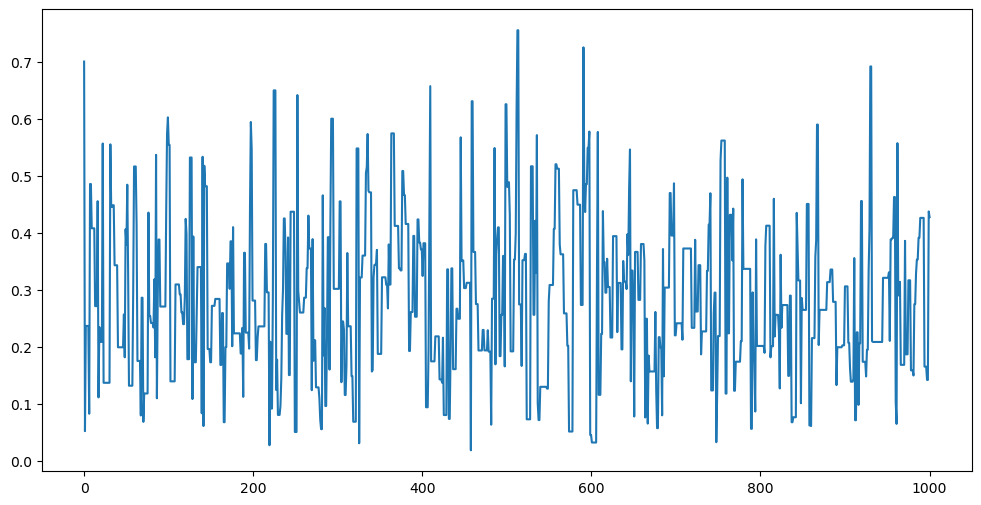

In [311]:
plt.figure(figsize=(12, 6))
plt.plot(np.linspace(0, num_iter, num_iter), X)
plt.show()


In [312]:
import seaborn as sns

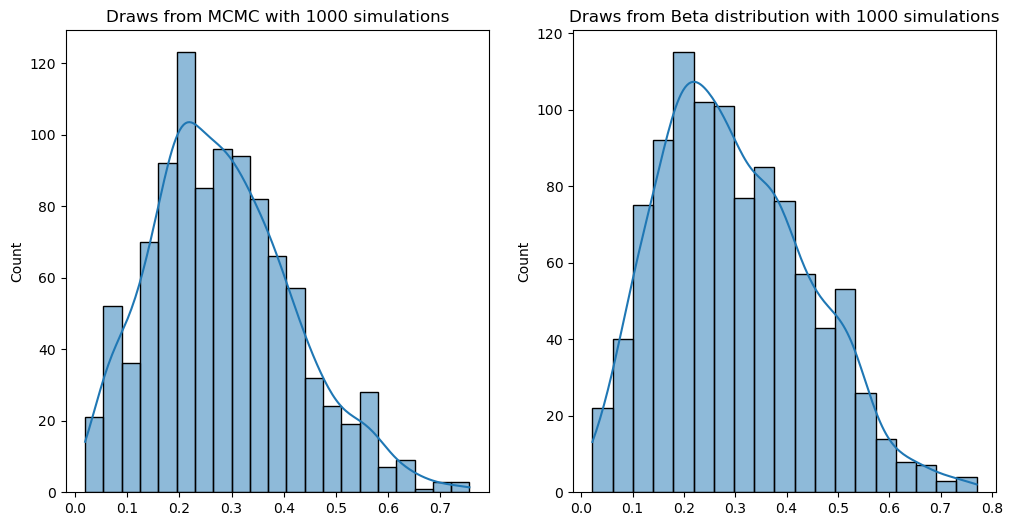

In [313]:
B = scipy.stats.beta.rvs(a = a, b = b, size = num_iter)

plt.figure(figsize=(12, 6))
plt.subplot(121)
sns.histplot(X, kde=True)
plt.title(f"Draws from MCMC with {num_iter} simulations")
plt.subplot(122)
sns.histplot(B, kde=True)
plt.title(f"Draws from Beta distribution with {num_iter} simulations")
plt.show()


Simulating 10000 times:

In [314]:
num_iter = 10**4
x0 = scipy.stats.uniform.rvs(size=1)


X, acceptance_ratio = MetropolisHasting(x0, target, conditional, simulate_conditional, num_iter)
B = scipy.stats.beta.rvs(a = a, b = b, size = num_iter)


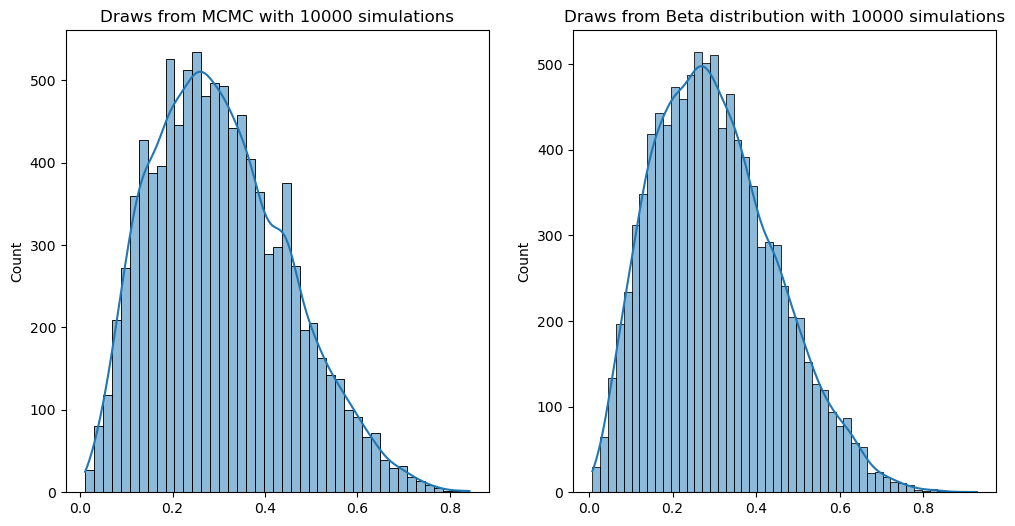

In [315]:


plt.figure(figsize=(12, 6))
plt.subplot(121)
sns.histplot(X, kde=True)
plt.title(f"Draws from MCMC with {num_iter} simulations")
plt.subplot(122)
sns.histplot(B, kde=True)
plt.title(f"Draws from Beta distribution with {num_iter} simulations")
plt.show()


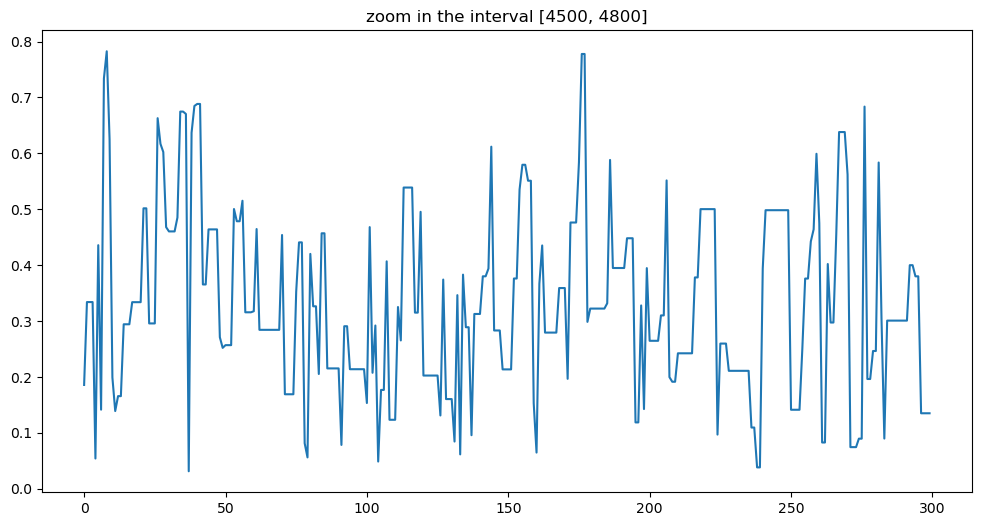

In [316]:
plt.figure(figsize=(12, 6))
plt.plot(X[4500:4800])
plt.title("zoom in the interval [4500, 4800]")
plt.show()

Lets make a table with several number of simulations and compare the mean and the variance of the sample generated by the algorithm and the sample generated by the distribution Beta itself.


In [317]:
Num_iters = [10**2, 10**3, 10**4, 10**5]
df = pd.DataFrame({}, columns=["num_simulations", "sample mean of X_t", "True mean", "sample variance of X_t", "True variance"], index= np.arange(len(Num_iters)))



for i, num_iter in enumerate(Num_iters):
    x0 = scipy.stats.uniform.rvs(size=1)
    X, _ = MetropolisHasting(x0, target, conditional, simulate_conditional, num_iter)
    B = scipy.stats.beta.rvs(a = a, b = b, size = num_iter)
    df.iloc[i]["num_simulations"] = num_iter
    df.iloc[i]["sample mean of X_t"] = X.mean()
    df.iloc[i]["sample variance of X_t"] = (X.std())**2


In [318]:
df["True mean"] = a/(a+b)
df["True variance"] = a*b/((a+b)**2 * (a +b +1))

df


,num_simulations,sample mean of X_t,True mean,sample variance of X_t,True variance
0,100,0.287223,0.3,0.019774,0.021
1,1000,0.30319,0.3,0.021349,0.021
2,10000,0.299039,0.3,0.021492,0.021
3,100000,0.300535,0.3,0.020972,0.021


Let us now create "iid" samples from a beta distribution using the MH algorithm. the idea is to simulate samples $X_t$ for $t=1,\dots, num_{iter}$ with $num_{iter}$ let's say equals to 100 and take the final value simulated as one of our samples. We will do this a num_sample times.

In [319]:
num_iter = 100
num_samples = 10**3

X = np.zeros(num_samples)

for t in range(num_samples):
    x0 = scipy.stats.uniform.rvs(size = 1)
    xt, _ = MetropolisHasting(x0, target, conditional, simulate_conditional, num_iter=num_iter)
    X[t] = xt[-1]


In [320]:
B = scipy.stats.beta.rvs(a = a, b = b, size = num_samples)

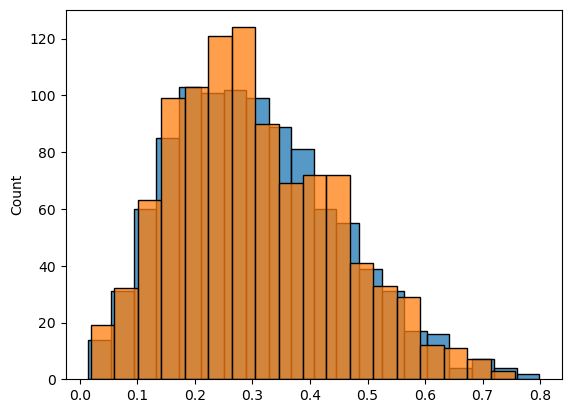

In [321]:
sns.histplot(X)
sns.histplot(B)
plt.show()

In [322]:
scipy.stats.kstest(X, scipy.stats.beta.cdf, (a, b))



KstestResult(statistic=0.022311230825184658, pvalue=0.6933022427815301)

In [323]:
scipy.stats.kstest(X, B)


KstestResult(statistic=0.03, pvalue=0.7593695685682871)

Since the $p$-value is big enough, we cannot reject the null hypothesis, that is, $X$ is most likely to be a draw samples from a beta distribution $\mathcal {B}(\alpha=2.7, \beta =6.3)$

### 2. MH Random Walk with normal likelihood and $t$ prior for the mean.

Suppose we have the following data of the change rate in personnel from last year to this year for $n$ companies. We know that if the likelihood is normal with known variance and a normal prior for the mean, then the posterior for the mean is a normal distribution from which we could draw samples very easily. In this example we are going to use the MH algorithm for two different priors: normal and t.

The data of the companies is the following:

$$
y= [1.2, 1.4, -0.5, 0.3, 0.9, 2.3, 1.0, 0.1, 1.3, 1.9] 
$$

then thw two models are:

model 1:
$$
\begin{align*}
& Y_1, \dots, Y_n |\mu,\sigma^2 \sim_{iid} \mathcal{N}(\mu, \sigma_0^2)\\
& \mu \sim N(\mu_0, \tau_0^2)
\end{align*}
$$

The posterior for this model is:
$$
\begin{align*}
p(\mu|y_1,\dots,y_n) &\propto p(y_1,\dots,y_n|\mu)p(\mu)\\
& \propto \exp\left(-\frac{1}{2}(\sum_{i}(y_i - \mu)^2)\right)\exp\left(-\frac{1}{2\tau_0^2}(\mu-\mu_0)^2\right)\\
& \propto \exp\left(-\frac{1}{2}(1/\tau_0^2 + n)\mu^2 + \mu(n\bar{y}_n + \mu_0/\tau_0^2) \right) = g_1(\mu)
\end{align*}
$$

model 2:

$$
\begin{align*}
& Y_1, \dots, Y_n |\mu,\sigma^2 \sim_{iid} \mathcal{N}(\mu, \sigma_0^2)\\
& \mu \sim t(0, 1, 1)
\end{align*}
$$

where $t(0,1,1)$ is a t distribution with location parameter $a = 0$, scale parameter $\tau = 1$ and degrees of freedom $\nu =1$. See the <a href = "https://en.wikipedia.org/wiki/Student%27s_t-distribution"> Wikipedia article </a> for more information on the t distribution.

The posterior for this model is:

$$
\begin{align*}
p(\mu|y_1,\dots,y_n) &\propto p(y_1,\dots,y_n|\mu)p(\mu)\\
& \propto \exp\left(-\frac{1}{2}(\sum_{i}(y_i - \mu)^2)\right)\frac{1}{1+\mu^2}\\
& \propto \frac{\exp\left(-\frac{n}{2}\mu^2 + n\bar{y}_n\mu\right)}{1+\mu^2} = g_2(\mu)
\end{align*}
$$


For stability and numerical reasons we will compute $\log(g(\mu))$ instead of $g(\mu)$ and the logarithm of the acceptance ratio $\log(\rho(x,y))$.

As candidate conditional distribution $q(x|y)$ we are going to choose a normal distribution with mean $y$, that is $q(x|y) =\mathcal{N}(y, \phi)$. By symmetry of the normal distribution with respect to its mean we have $q(x|y) = q(y|x)$, that is, the gaussian density centered at $y$ evaluated in $x$ produces the same value as the gaussian centered at $x$ and evaluated at $y$, therefore the factors $q(x|y), q(y|x)$ will cancel out in the expression for $\rho$ above and the acceptance ratio will be in this case:
$$
\rho(x, y) = \frac{g(y)}{g(x)}.
$$

This particular form of the alogrithm is called the Random Walk Metropolis Hastings or simply the Metropolis Algorithm, see <a href="https://en.wikipedia.org/wiki/Metropolis%E2%80%93Hastings_algorithm"> here </a> for the intuition and derivation.


In [324]:
def log_g1(mu, n, ybar, mu0, tau0_sq):
    
    return -0.5*(1/tau0_sq + n)*mu**2 + (n*ybar +mu0/tau0_sq)*mu

def log_g2(mu, n, ybar):
    
    return n*(ybar*mu - mu**2/2) - np.log(1+mu**2)

def Random_Walk_MH(mu_init, n, ybar, n_iter, log_target, sig_candidate,  *params):

    """
    Implemente Metropolis Hastings to draw samples from the posterior distribuition
    for the mean of normal data with prior given by normal or t student (depending on log_target parameter).

    The candidate distribution for mu_i+1 is N(mu_i, sig_candidate)
    
    """

    mu_output = np.zeros(n_iter)
    # step 1: initialize
    mu_now = mu_init
    log_target_now = log_target(mu_now, n, ybar, *params)
    accept = 0  # to track the rate of acceptance

    for i in range(n_iter):

        mu_cand = scipy.stats.norm.rvs(loc = mu_now, scale = sig_candidate, size =1)
        
        # step 2: reject accept:
        log_target_cand  = log_target(mu_cand, n, ybar, *params)
        log_rho = log_target_cand - log_target_now  # log of acceptance ratio
        rho = np.exp(log_rho)   #acceptance ratio
        u = scipy.stats.uniform.rvs()  # uniform r.v in [0, 1]

        if u < rho:
            mu_now = mu_cand
            accept += 1   
            log_target_now = log_target_cand

        mu_output[i] = mu_now

    return mu_output, accept/n_iter






In [325]:
y = np.array([1.2, 1.4, -0.5, 0.3, 0.9, 2.3, 1.0, 0.1, 1.3, 1.9])
n = len(y)
ybar = np.mean(y)
mu0 = 0     # prior mean of mu
tau0_sq = 1  #prior standard deviation mu

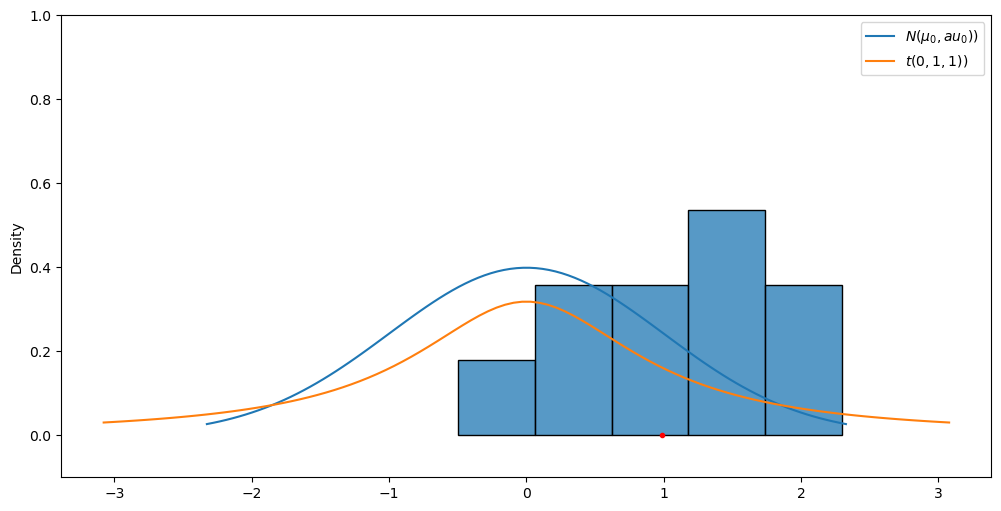

In [326]:
# plot data and prior distribution
x1 = np.linspace(scipy.stats.norm.ppf(0.01, loc = mu0, scale =tau0_sq), scipy.stats.norm.ppf(0.99, loc = mu0, scale =tau0_sq), 100)
x2 = np.linspace(scipy.stats.t.ppf(0.1, df =1,  loc = 0, scale = 1), scipy.stats.t.ppf(0.9, df = 1, loc = 0, scale = 1), 100)

plt.figure(figsize=(12,6))
sns.histplot(y, stat="density")
plt.plot(x1, scipy.stats.norm.pdf(x1, loc = mu0, scale = tau0_sq), label = "$N(\mu_0, \tau_0))$")
plt.plot(x2, scipy.stats.t.pdf(x2, df =1, loc = mu0, scale = tau0_sq), label = "$t(0, 1, 1))$")
plt.plot(ybar, 0., ".", color = 'red')
plt.ylim((-0.1, 1))
plt.legend()
plt.show()

In [327]:
np.random.seed(89)

mu_init = 0.0
n_iter = 1000
sig_candidate = 2.0
posterior11, acceptance_ratio1 = Random_Walk_MH(mu_init, n, ybar, n_iter, log_g1,
                                              sig_candidate, mu0, tau0_sq)

posterior21, acceptance_ratio2 = Random_Walk_MH(mu_init, n, ybar, n_iter, log_g2,
                                              sig_candidate)

Lets make a traceplot for the samples:

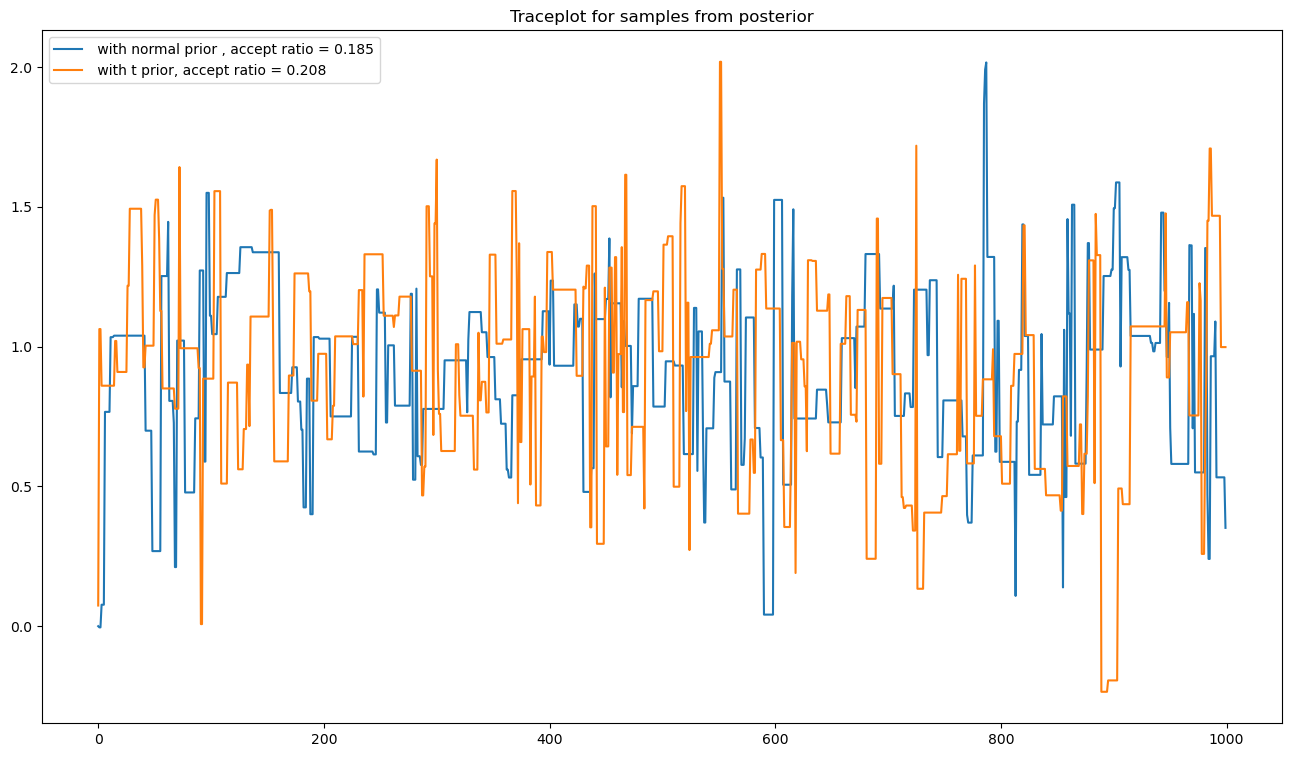

In [328]:
plt.figure(figsize=(16,9))
plt.plot(np.arange(n_iter), posterior11, label = " with normal prior , accept ratio = " + str(acceptance_ratio1))
plt.plot(np.arange(n_iter), posterior21, label = " with t prior, accept ratio = " + str(acceptance_ratio2))
plt.title("Traceplot for samples from posterior")
plt.legend()
plt.show()

In [329]:
print(f"Estimated Posterior means are: {np.mean(posterior11)} {np.mean(posterior21)}")

Estimated Posterior means are: 0.9073951005020989 0.9091900499332689


Lets plot the theoretical posterior density, which in this case is known, and the empiric distribution for the samples obtained with the algorithm:


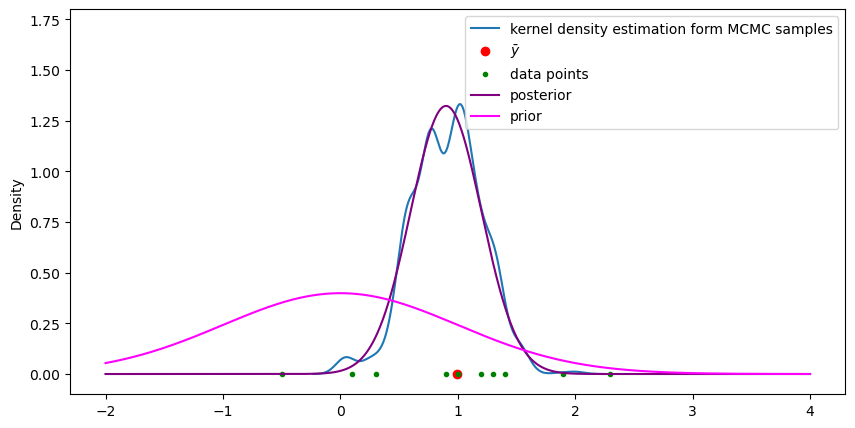

In [330]:
# posterior mean and variance:
sig_0 = 1
data_prec = n/sig_0**2   # precision of data defined as the inverese of the variance of ybar : n/sigma_0^2
prior_prec = 1/tau0_sq**2 # prior precision of mu
posterior_prec = data_prec + prior_prec

sigma_post = np.sqrt(1/posterior_prec)
mu_post = ybar * data_prec/posterior_prec + mu0 * prior_prec/posterior_prec

griid = np.linspace(-2,4, 1000)

plt.figure(figsize=(10, 5))
sns.kdeplot(posterior11, label = "kernel density estimation form MCMC samples")
plt.plot(ybar, 0 , "o", color = "red", label = "$\\bar{y}$")
plt.plot(y, np.zeros(n), ".", label = 'data points', color = "green")
plt.plot(griid, scipy.stats.norm.pdf(griid, loc = mu_post, scale = sigma_post), color = "purple", label = "posterior")
plt.plot(griid, scipy.stats.norm.pdf(griid, loc = mu0, scale = tau0_sq),color = "magenta", label = "prior")
plt.legend()
plt.ylim((-0.1, 1.8))
plt.show()

Note that for the normal prior $\mathcal{N}(0, 1)$ the posterior mean is:


In [331]:
mu_post

0.8999999999999999

meanwhile the estimated posterior mean using the MCMC samples is:


In [332]:
np.mean(posterior11)

0.9073951005020989

Although the estimation for the mean is quite good, the estimated density (the blue curve in the plot above) does not seem to be very similar to the true psterior density. The reason for this is explained by the *effective sample size*. Although we draw 1000 samples with the MH algorithm, these samples are not independent, the are correlated. In fact, the sample auto-correlation for these are:

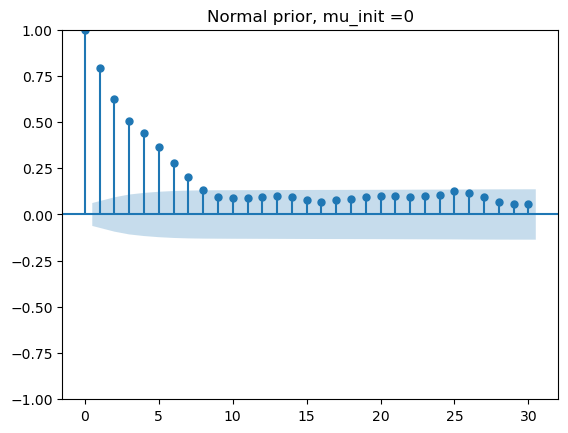

In [333]:
fig = tsaplots.plot_acf(posterior11,title="Normal prior, mu_init =0")


One way to assess the *goodness* of our estimator is to compute the *effective sample size* (*ess*) that will tell us how many independent samples would produce the estimator. That is, although we produce 1000 samples, the result of the estimator is as if we had *ess* number of independent samples. 

To make some diagnosis of the samples draw with pymc3 we will use the python library <a href = "https://python.arviz.org/en/stable/index.html">ArviZ</a> a module for exploratory analysis of Bayesian models.

For instance, in this case the estimated *ess* is:

In [334]:
arviz.ess(posterior11)

78.73625373328707

This means that the results we obtained with the MCMC samples are equivalent to the results we would obtained with 168 independent samples. The nearer to the number of samples the better are the MCMC samples. 
We will return to this point when we talk about the standard error for the estimator of the mean using MCMC samples.

For the t prior the correlation and the effective sample size are:

the estimated effective sample size is: 70.12735181805114


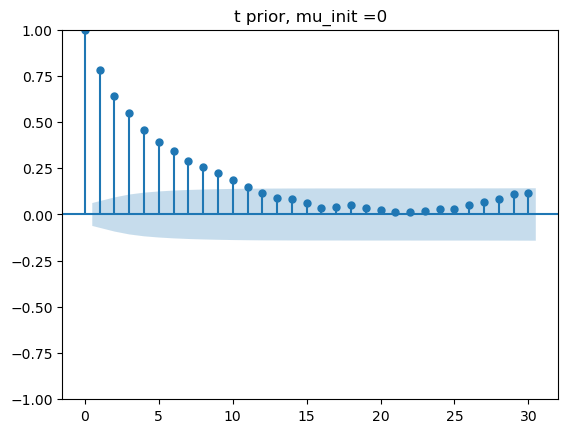

In [335]:
fig = tsaplots.plot_acf(posterior21,title="t prior, mu_init =0")


print(f"the estimated effective sample size is: {arviz.ess(posterior21)}")

we can also plot the autocorrelation between samples using the function **plot_autocorr** from Arviz:

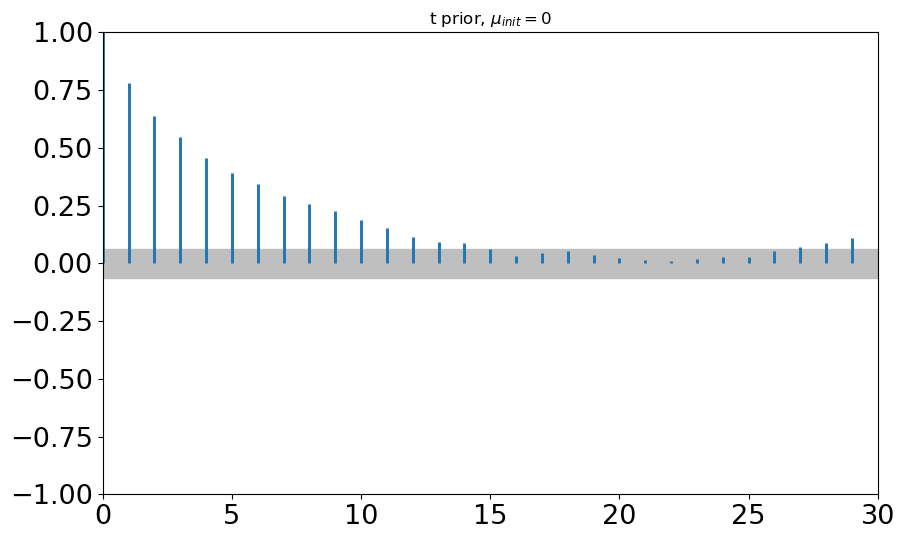

In [336]:
arviz.plot_autocorr(posterior21, max_lag= 30, figsize=(10,6))
plt.title("t prior, $\mu_{init} =0$")
plt.show()

<h3> Dependance on initialization point.</h3>


What if we initialize $\mu$ very far form 0, e.g, $\mu_{init}=30$


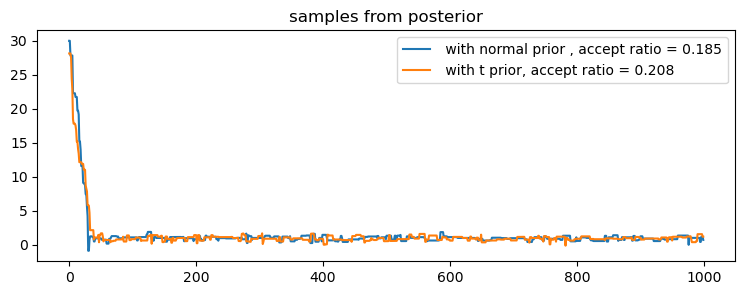

In [337]:
mu_init = 30.0
n_iter = 1000
sig_candidate = 2.0
posterior12, acceptance_ratio12 = Random_Walk_MH(mu_init, n, ybar, n_iter, log_g1,
                                              sig_candidate, mu0, tau0_sq)

posterior22, acceptance_ratio22 = Random_Walk_MH(mu_init, n, ybar, n_iter, log_g2,
                                              sig_candidate)

plt.figure(figsize=(9,3))
plt.plot(np.arange(n_iter), posterior12, label = " with normal prior , accept ratio = " + str(acceptance_ratio1))
plt.plot(np.arange(n_iter), posterior22, label = " with t prior, accept ratio = " + str(acceptance_ratio2))
plt.title("samples from posterior")
plt.legend()
plt.show()

From the traceplot above we can observe that it took a while to reach the stationary distribution. We can discard the first 50-100 samples and compute the estimated posterior mean using the 900-950 samples left.

In [338]:
mu_keep1 = posterior12[100:].mean()
mu_keep2 = posterior22[100:].mean()

print(f"the estimated posterior mean for both priors are: {mu_keep1, mu_keep2}")


the estimated posterior mean for both priors are: (0.9355339352816968, 0.9120424653374526)


Compare these estimated values with the one computed without discarding the first 100 samples:


In [339]:
mu_post1 = posterior12.mean()
mu_post2 = posterior22.mean()

print(mu_post1, mu_post2)

1.4280440867890907 1.3716528388614584


And also compare these values with the ones obtained using the samples with initial $\mu$ given by 0, a number closer to the sample mean of data $Y$. These values are: 

In [340]:
print(f"Estimated Posterior means for mu_init = 0.0 are: {np.mean(posterior11)} {np.mean(posterior21)}")

Estimated Posterior means for mu_init = 0.0 are: 0.9073951005020989 0.9091900499332689


<h3> Standard error for the estimator of the posterior mean. </h3>

If we were to estimate the mean of a distribution using iid samples $Y_1,\dots, Y_n ~Y$, we know that the standard error of the estimator is:
$$
se(\hat{\mu}) = \frac{\widehat{\mathbb{V}(Y)}}{n}
$$
this is known as the Monte Carlo error.

Since we are not drawing independent samples, for the algorithm produce a Markov chain, the samples might be (and definitely are) correlated, we cannot expect the same standard error for the estimator of the posterior mean. 

First, lets make some correlation plots for the samples obtained above:



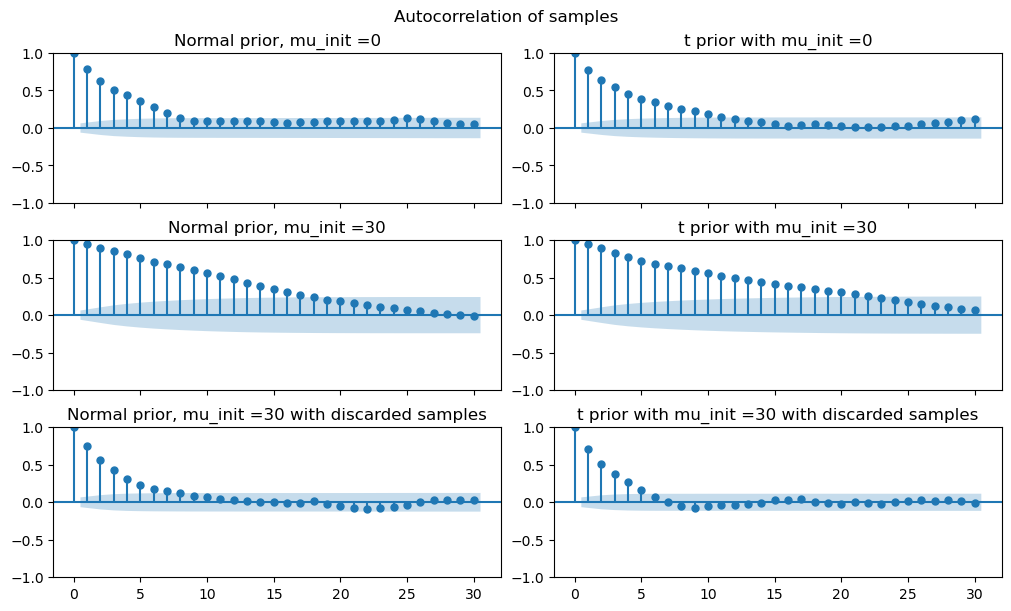

In [341]:
fig, axs = plt.subplots(nrows=3, ncols= 2, figsize=(10,6), sharex=True, squeeze=False, constrained_layout = True)
tsaplots.plot_acf(posterior11, ax = axs[0,0], title="Normal prior, mu_init =0")
tsaplots.plot_acf(posterior12, ax = axs[1,0], title="Normal prior, mu_init =30")
tsaplots.plot_acf(posterior12[100:], ax = axs[2,0], title="Normal prior, mu_init =30 with discarded samples")
tsaplots.plot_acf(posterior21, ax = axs[0,1], title = "t prior with mu_init =0")
tsaplots.plot_acf(posterior22, ax = axs[1,1], title= "t prior with mu_init =30")
tsaplots.plot_acf(posterior22[100:], ax = axs[2,1], title= "t prior with mu_init =30 with discarded samples")
fig.suptitle("Autocorrelation of samples")
plt.show()

Note that for the samples generated with $\mu_{init}=30$ the correlation starts vanishing after the lag 25, at least for the case where we did not discard the first 100 samples. When these samples are discarded the correlation vanishes after 5 to 10 lags. This is similar to the samples with $\mu_{init} =0$. 

Now that we saw that these are not independent samples, what is the standard error for the estimator of the posterior mean of $\theta$? Since the estimator of the posterior mean of $\mu$ is simply the sample mean $\bar{\mu}_n = \frac{1}{n}\sum_{i=1}^n\mu^{(i)}$ of the samples $\mu^{(i)}$, this standard error is an estimator of the MCMC variance. The MCMC variance is:

$$
\begin{align*}
Var_{MCMC}(\bar{\mu}_n) &=\mathbb{E}((\bar{\mu}_n - \mathbb{E}(\mu))^2) \\
&= \mathbb{E}\left\lbrace \frac{1}{n^2}\sum_{i=1}^n (\mu^{(i)} - \mathbb{E}(\mu))^2\right\rbrace\\
& = \frac{1}{n^2}\sum_{i=1}^n \mathbb{E}((\mu^{(i)} - \mathbb{E}(\mu))^2) + \frac{1}{n^2}\sum_{\underset{i\neq j}{i, j=1}}^n\mathbb{E}((\mu^{(i)} - \mathbb{E}(\mu))(\mu^{(j)} - \mathbb{E}(\mu)))\\
&= Var_{MC}(\bar{\mu}_n) + \frac{1}{n^2}\sum_{\underset{i\neq j}{i, j=1}}^n\mathbb{E}((\mu^{(i)} - \mathbb{E}(\mu))(\mu^{(j)} - \mathbb{E}(\mu)))
\end{align*}
$$

That is, the MCMC variance is the sum of the MC variance plus a term of the correlation of the samples within the Markov chain. This extra term is in general positive and therefore the the MCMC is higher than the MC vatiance, this means that it is expected that the MCMC estimator of the posterior mean to be further away from the true posterior mean that the MC estimator is. 


The function *mcse* from the ArviZ library is useful to compute the standar error for the estimator of the mean. In fact, we will see below that when using PyMC3 to generate MCMC samples, the summary function will give us the standard error for the posterior mean and variance.

For now, let us plot the standard error for the estimator of the quantiles of the MCMC *posterior11* obtained above with $\mu_init = 0$ using the function *plot_mcse* form ArviZ library.

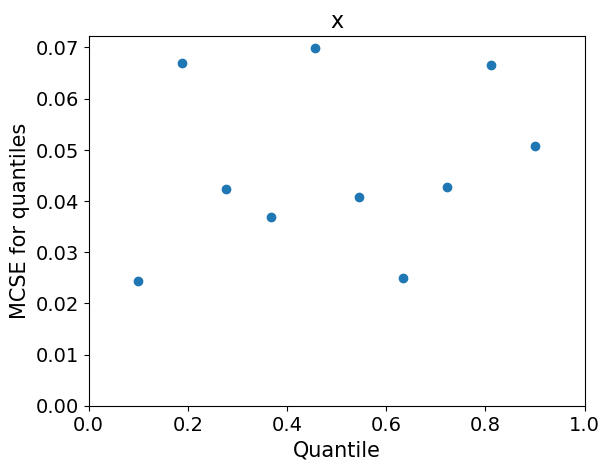

In [388]:
arviz.plot_mcse(posterior11, n_points=10)
plt.show()

<h2>Using PyMC3 </h2>

In this section we will reproduce the results obtained above by means of the Python library <strong><a href="https://www.pymc.io/welcome.html">PyMC3 </a> </strong>. 

We tell the function *pymc3.sample* to run cores=3 independent Markov Chains. The plot of the posterior will consist then of thre curves, one for each sample set.

In [343]:
with pymc3.Model() as model_1:
    mu_prior = pymc3.Normal('mu', mu = 0, sigma = 1)
    y_data = pymc3.Normal('y', mu = mu_prior, sd = 1, observed = y) 
    infered_data = pymc3.sample(draws = n_iter, cores = 3, return_inferencedata=True)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (3 chains in 3 jobs)
NUTS: [mu]
WARNING (theano.link.c.cmodule): install mkl with `conda install mkl-service`: No module named 'mkl'
WARNING (theano.link.c.cmodule): install mkl with `conda install mkl-service`: No module named 'mkl'
WARNING (theano.link.c.cmodule): install mkl with `conda install mkl-service`: No module named 'mkl'


/Users/juliana/opt/anaconda3/envs/Gatulin/lib/python3.10/site-packages/scipy/stats/_continuous_distns.py:624: RuntimeWarning: overflow encountered in _beta_ppf
  return _boost._beta_ppf(q, a, b)
/Users/juliana/opt/anaconda3/envs/Gatulin/lib/python3.10/site-packages/scipy/stats/_continuous_distns.py:624: RuntimeWarning: overflow encountered in _beta_ppf
  return _boost._beta_ppf(q, a, b)
/Users/juliana/opt/anaconda3/envs/Gatulin/lib/python3.10/site-packages/scipy/stats/_continuous_distns.py:624: RuntimeWarning: overflow encountered in _beta_ppf
  return _boost._beta_ppf(q, a, b)
Sampling 3 chains for 1_000 tune and 1_000 draw iterations (3_000 + 3_000 draws total) took 20 seconds.


Lets make some diagnostics using the ArviZ library:

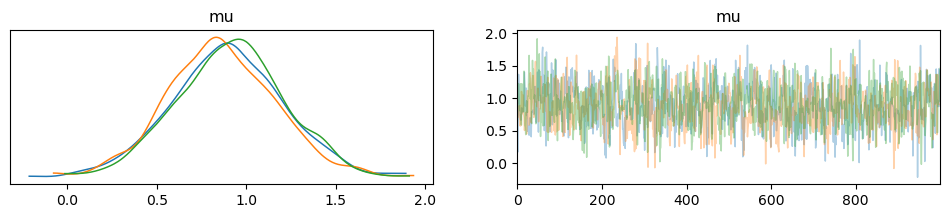

In [344]:
arviz.plot_trace(infered_data, var_names='mu', compact= False)
plt.show()


The plot on the left contains the *Kernel Density Estimation* (kde) for the posterior of the 3 sets of samples. The plot on the right is the value of the samples for each chain.

We can use the function *summary* from *arviz* library to see the details of the posterior. It returns a pandas data frame with a bunch of statistics usefull for the diagnosis of the chain computed. 

The data returned is: the posterior mean and standard deviation, a 95% high density interval (hdi, which is the smallest interval containing the 95%  of the probability density or the minimum width Bayesian Credible Interval), the msce_mean and mcse_sd (the standard error for the estimators of the mean and standard deviation), the effective sample size using two methods: bulk and tail (these are ess_bulk and ess_tail of which we will not discuss any further). 

And finally the r_hat statistic which is the ratio of estimated variability whithin chains by the estimated variability between chains. If we arrived at stationarity this number should be very near to 1, meaning that: if all chains have converged to the stationary distribution, the variability between chains should be relatively small, and the potential scale reduction factor r_hat. If the values are much higher than one, then we would conclude that the chains have not yet converged.

Documentation for the r_hat can be found <a href="https://python.arviz.org/en/stable/api/generated/arviz.rhat.html#arviz.rhat"> here </a> and also the reference for it can be found <a href="https://arxiv.org/abs/1903.08008"> here </a>.


In [387]:
arviz.summary(infered_data, hdi_prob=0.95)


,mean,sd,hdi_2.5%,hdi_97.5%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
mu,0.889,0.306,0.287,1.491,0.009,0.006,1207.0,1803.0,1.0


Go to the Section <a href="IntrotoPyMC3">A Quick Intro to PyMC3</a> for a tutorial for begginers in PyMC3.

<a href="MetropolisHastingsAlg" class="previous"> &laquo; Back<a>  <a href="index" class="next"> &raquo; Table of Contents<a> 